In [14]:
###########
# Imports #
###########

# Remove annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# Standard package imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Utility imports
import os
import random
from tqdm.notebook import tqdm, trange
from p_tqdm import p_umap
# Preprocessing imports
from category_encoders import (
    OneHotEncoder,
    OrdinalEncoder,
    TargetEncoder,
    LeaveOneOutEncoder,
    WOEEncoder,
    CountEncoder,
)
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    QuantileTransformer,
)
# ML imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

clf = LogisticRegression(max_iter=10000)
savepath = 'datasets/'

################
# Dictionaries #
################

def dp(test):
    '''Demographic Parity'''
    upr = test[test.pa == 0].pred.value_counts(normalize=True).get(1, 0)
    fpr = test[test.pa == 1].pred.value_counts(normalize=True).get(1, 0)
    dp = abs(fpr - upr)
    return dp

def eo(test):
    '''Equality of Opportunity'''
    f_fnr = test[(test.pa == 1) & (test.label == 1)].pred.value_counts(normalize=True).get(0, 0)
    u_fnr = test[(test.pa == 0) & (test.label == 1)].pred.value_counts(normalize=True).get(0, 0)
    eo = abs(f_fnr - u_fnr)
    return eo

def eqOdds(test):
    '''Equalised Odds'''
    f_fnr = test[(test.pa == 1) & (test.label == 1)].pred.value_counts(normalize=True).get(0, 0)
    u_fnr =test[(test.pa == 0) & (test.label == 1)].pred.value_counts(normalize=True).get(0, 0)
    f_fpr = test[(test.pa == 1) & (test.label == 0)].pred.value_counts(normalize=True).get(1, 0)
    u_fpr = test[(test.pa == 0) & (test.label == 0)].pred.value_counts(normalize=True).get(1, 0)
    eq =  abs(f_fnr - u_fnr) + abs(f_fpr - u_fpr)
    return eq

def accu(test):
    return 1 - accuracy_score(test.label, test.pred)

# Dictionary of fairness metrics
fair_funcs = {
    'dp': dp,
    'eo': eo,
    'eqOdds': eqOdds,
    'accu': accu,
}

# Dataset Dictionaries
CNE = {
    'df': 'compas_ne.csv',
    'pa': 'race',
    'label': 'two_year_recid',
}
COMPAS = {
    'df': 'compas_onehot.csv',
    'pa': 'race',
    'label': 'label',
}
German = {
    'df': 'german_onehot.csv',
    'pa': 'gender',
    'label': 'label',
}
GNE = {
    'df': 'german_ne.csv',
    'pa': 'gender',
    'label': 'label',
}
Income = {
    'df': 'income_onehot.csv',
    'pa': 'sex',
    'label': 'label',
}
Income_Frac = {
    'df': 'income_frac.csv',
    'pa': 'sex',
    'label': 'label',
}
INEMV = {
    'df': 'income_ne_mv.csv',
    'pa': 'sex',
    'label': 'label',
}
INE = {
    'df': 'income_no_enc.csv',
    'pa': 'sex',
    'label': 'label'
}
Titanic = {
    'df': 'Titanic_onehot.csv',
    'pa': 'Sex',
    'label': 'Survived',
}

# Dset dictionary
DSets = {
    'CNE': CNE,
    'COMPAS': COMPAS,
    'German': German,
    'GNE': GNE,
    'Income': Income,
    'Income_Frac': Income_Frac,
    'INE': INE,
    'INEMV': INEMV,
    'Titanic': Titanic,
}

# Preprocessing Dictionaries
class Identity:
    def fit(self, X, y):
        return self
    def transform(self, X):
        return X

def make_encode_impute_dicts(df_id, dset_d=DSets):
    global to_encode
    global encode_d
    global impute_d
    df_name = dset_d[df_id]['df']
    df = pd.read_csv(savepath + df_name)
    to_encode = list(df.select_dtypes(include='object').columns)
    encode_d = {
        'One Hot': [OneHotEncoder(cols=to_encode, drop_invariant=True)],
        'Ordinal': [OrdinalEncoder(cols=to_encode, drop_invariant=True)],
        'Target': [TargetEncoder(cols=to_encode, drop_invariant=True)],
        'LOO': [LeaveOneOutEncoder(cols=to_encode, drop_invariant=True)],
        'WOE': [WOEEncoder(cols=to_encode, drop_invariant=True)],
        'Count': [CountEncoder(cols=to_encode, drop_invariant=True)],
    }
    encoder = OneHotEncoder(cols=to_encode)
    impute_d = {
        'Mean': [encoder, SimpleImputer(strategy='mean')],
        'Median': [encoder, SimpleImputer(strategy='median')],
        'Most Frequent': [encoder, SimpleImputer(strategy='most_frequent')],
    }

resampling_d = {
    'No Resampling': [Identity()],
    'Undersampling': [RandomUnderSampler()],
    'Oversampling': [RandomOverSampler()],
}

scale_d = {
    'No Scaling': [Identity()],
    'MaxAbs': [MaxAbsScaler()],
    'MinMax': [MinMaxScaler()],
    'Normalizer': [Normalizer()],
    'QuantileTransformer': [QuantileTransformer()],
}

def make_fSel_dict(df_id, dset_d=DSets):
    global fSel_d
    df_name = dset_d[df_id]['df']
    df = pd.read_csv(savepath + df_name)
    n_feats = df.shape[1] - 1
    n_sel = 10 if n_feats > 10 else n_feats - 1
    fSel_d = {
        'No Selection': [Identity()],
        'Variance Threshold': [VarianceThreshold(0.1)],
        'K Best': [SelectKBest(k=n_sel)],
    }

def update_dicts(df_id, dset_d=DSets):
    global pre_dicts
    make_encode_impute_dicts(df_id, dset_d)
    make_fSel_dict(df_id, dset_d)
    pre_dicts = {
        'encode': encode_d,
        'impute': impute_d,
        'sample': resampling_d,
        'scale': scale_d,
        'sel': fSel_d,
    }

###########################
# Preprocessing Functions #
###########################

def relab(name, dset_d=DSets, savepath=savepath):
    '''Rename PA and label adequately'''
    df = pd.read_csv(savepath + dset_d[name]['df'], header=0)
    pa = dset_d[name]['pa']
    label = dset_d[name]['label']
    df.rename(columns={pa:'pa', label:'label'}, inplace=True)
    # Change PA to 0, 1 for unfav, fav resp.
    prs = {s: df[df.pa == s].label.value_counts(normalize=True)[1]
           for s in df.pa.unique()}
    df.pa = [1 if s == max(prs) else 0 for s in df.pa]
    return df

def tt_split(df, test_frac=0.2):
    test = df.dropna().sample(frac=test_frac)
    train = df.drop(test.index)
    tt = {'train': train, 'test': test}
    return tt

def preprocess(df, task_list):
    df_mod = df.copy()
    for task in task_list:
        X = df_mod.drop('label', axis=1).dropna(axis=1, how='all')
        y = df_mod.label.values
        pa = df_mod.pa
        cols = X.columns
        df_fit = task.fit(X, y)
        # General case
        if not hasattr(task, 'fit_resample'):
            tX = df_fit.transform(X)
        # Special case for resampling methods
        else:
            tX, y = task.fit_resample(X, y)
        # Special cases for column modifiers
        if hasattr(df_fit, 'get_feature_names'):
            try:
                cols = df_fit.get_feature_names(input_features=cols)
            except (NameError, TypeError):
                cols = df_fit.get_feature_names()
        elif hasattr(df_fit, 'get_support'):
            sup = df_fit.get_support(indices=True)
            cols = [cols[s] for s in sup]
        df_mod = pd.DataFrame(tX, columns=cols)
        if not 'pa' in df_mod.columns:
            df_mod['pa'] = pa
        df_mod['label'] = y    
    return df_mod

def predict(train, test, clf=clf):
    '''Add predictions to test made by train-learned classifier'''
    tst = test.copy()
    X_train = train.drop(['label',], axis=1)
    y_train = train.label
    X_test = tst.drop(['label',], axis=1)
    clf.fit(X_train, y_train)
    tst['pred'] = clf.predict(X_test)
    return tst

def get_fairness(df, prep_d, fair_d=fair_funcs, cv=False, clf=clf):
    '''Get fairness metrics on test resulting from preprocessing train with the tasks in prep_d'''
    preps = {p: preprocess(df, prep_d[p]) for p in prep_d}
    if cv:
        preds = {}
        for p in preps:
            prp = preps[p].copy()
            X = prp.drop('label', axis=1)
            y = prp.label
            cv_pred = cross_val_predict(clf, X, y, cv=4, n_jobs=-1)
            preds[p] = prp.assign(pred=cv_pred)
    else:
        splits = {p: tt_split(preps[p]) for p in preps}
        outs = {'trains': {p: splits[p]['train'] for p in preps},
                'tests': {p: splits[p]['test'] for p in preps}}
        preds = {p: predict(outs['trains'][p], outs['tests'][p])
                 for p in preps}
    fair_metrics = {f: {p: fair_d[f](preds[p]) for p in preds}
                    for f in fair_d}
    return fair_metrics

def combine_reps(reps):
    dfs = []
    # Create dataframe of results
    for rep in reps:
        row_list = []
        for fair_metric in rep.keys():
            for pre_task in rep[fair_metric].keys():
                temp_dict = {
                    'pre_task': pre_task,
                    'fair_metric': fair_metric,
                    'fair_value': rep[fair_metric][pre_task],
                }
                row_list.append(temp_dict)
        results_df = pd.DataFrame(row_list)
        dfs.append(results_df)
    df = pd.concat(dfs, ignore_index=True)
    return df

#######################
# Auxiliary Functions #
#######################

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def boxes(res, dset, pre):
    sns.set_theme(context='notebook', style='whitegrid')
    sns.set(rc={'figure.figsize':(5, 5)})
    sns.set_palette('colorblind')

    g = sns.catplot(x="fair_value", y="pre_task", col="fair_metric", data=res, kind='box', sharex=False)
    g.set_axis_labels('', '')
    axes = g.axes.flatten()
    titles = ["Demographic Parity", "Equality of Opportunity", "Equalised Odds", "1 - Accuracy"]
    for i, title in enumerate(titles):
        axes[i].set_title(title)
    plt.savefig(f"plots/separate/{dset}_{pre}.pdf", bbox_inches='tight')
    plt.show()

In [15]:
n_rep = 16
seed_everything(42)
seeds = [random.randint(1, 100000) for i in range(n_rep)]

def repetition(seed):
    seed_everything(seed)
    df = relab(dset, DSets)
    fm = get_fairness(df, pre_dicts[pre], fair_funcs, cv=False)
    return fm

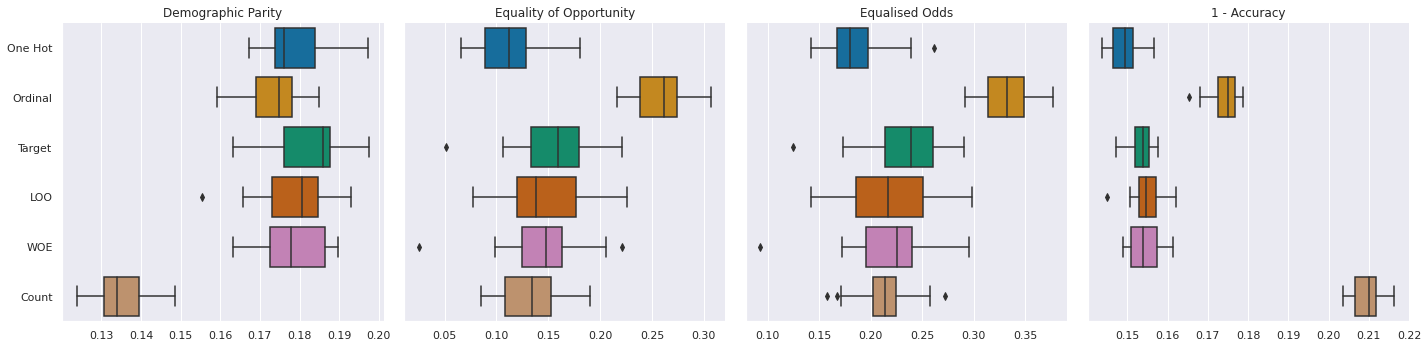

In [16]:
dset = 'INE'
pre = 'encode'
update_dicts(dset)

reps = [repetition(seed) for seed in tqdm(seeds, desc='Seed')]
res = combine_reps(reps)
res.to_csv(f'results/separate/{dset}_{pre}.csv', index=False)
boxes(res, dset, pre)

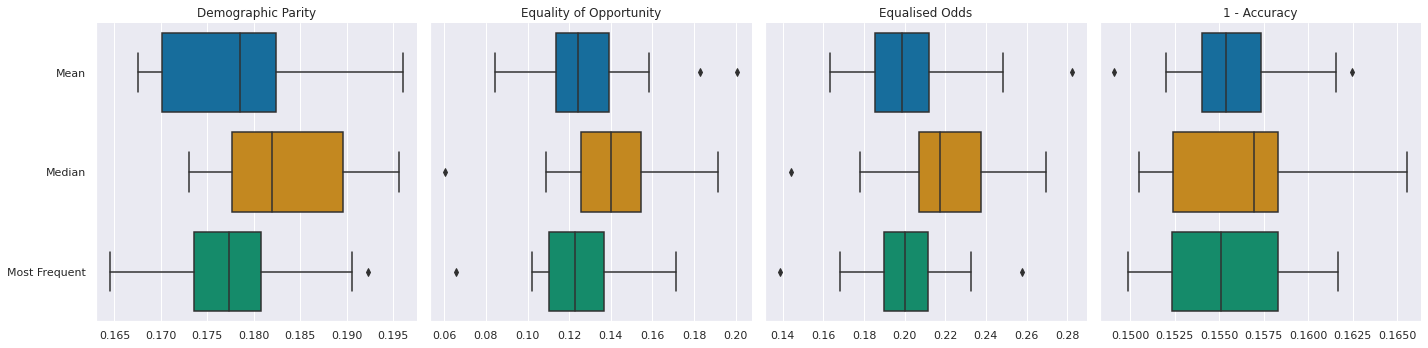

In [17]:
dset = 'INEMV'
pre = 'impute'
update_dicts(dset)

reps = [repetition(seed) for seed in tqdm(seeds, desc='Seed')]
res = combine_reps(reps)
res.to_csv(f'results/separate/{dset}_{pre}.csv', index=False)
boxes(res, dset, pre)

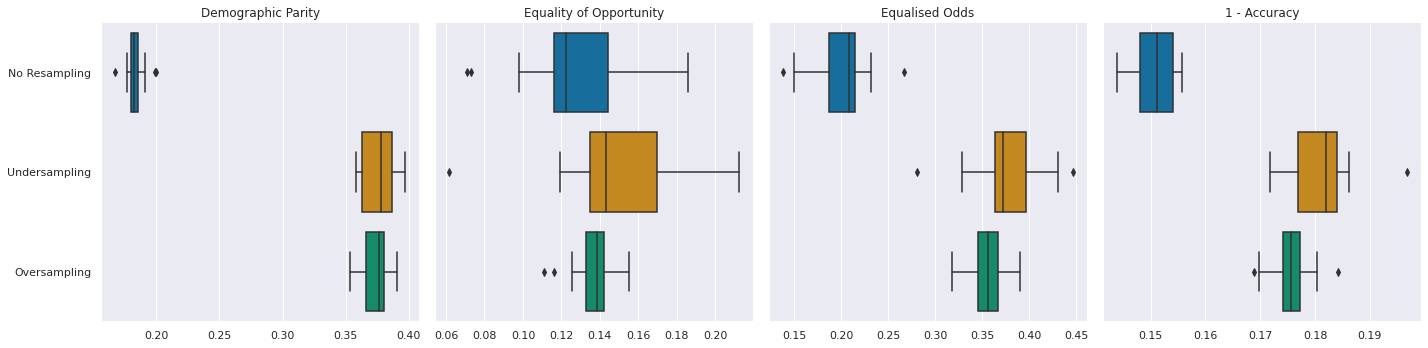

In [18]:
dset = 'Income'
pre = 'sample'
update_dicts(dset)

reps = [repetition(seed) for seed in tqdm(seeds, desc='Seed')]
res = combine_reps(reps)
res.to_csv(f'results/separate/{dset}_{pre}.csv', index=False)
boxes(res, dset, pre)

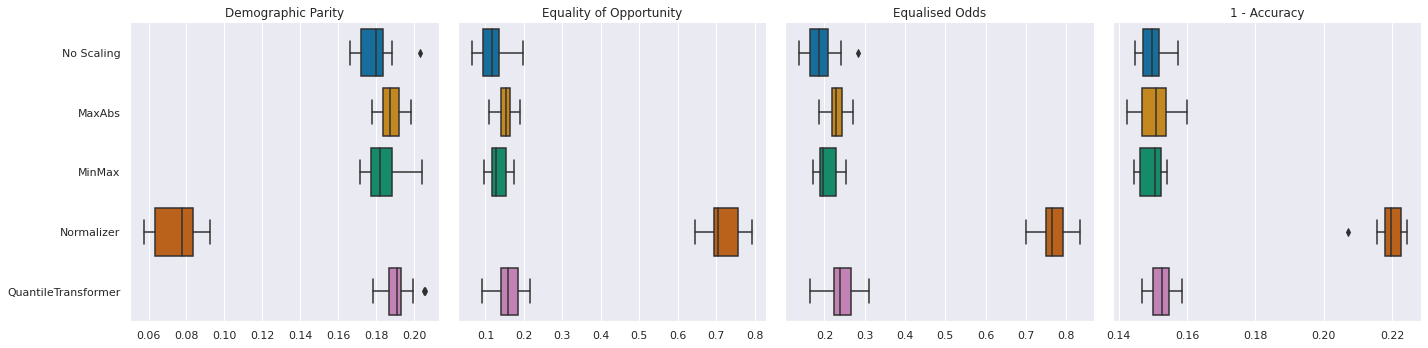

In [19]:
dset = 'Income'
pre = 'scale'
update_dicts(dset)

reps = [repetition(seed) for seed in tqdm(seeds, desc='Seed')]
res = combine_reps(reps)
res.to_csv(f'results/separate/{dset}_{pre}.csv', index=False)
boxes(res, dset, pre)

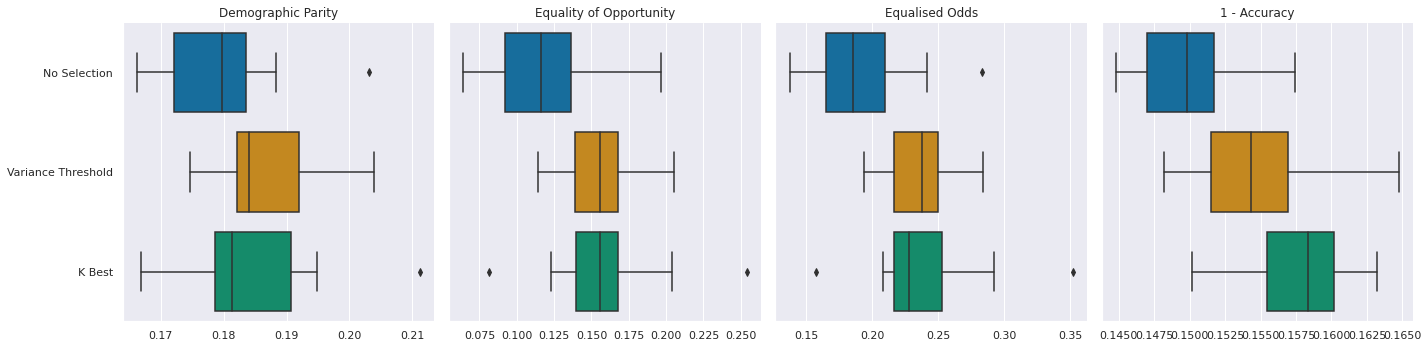

In [20]:
dset = 'Income'
pre = 'sel'
update_dicts(dset)

reps = [repetition(seed) for seed in tqdm(seeds, desc='Seed')]
res = combine_reps(reps)
res.to_csv(f'results/separate/{dset}_{pre}.csv', index=False)
boxes(res, dset, pre)

## Kruskal-Wallis tests

In [112]:
from scipy import stats

exps = {
    'encode': 'INE',
    'impute': 'INEMV',
    'sample': 'Income',
    'scale': 'Income',
    'sel': 'Income',
}

kruskal_d = {}
for exp in exps:
    kruskal_d[exp] = {}
    pre = exp
    dset = exps[exp]
    df = pd.read_csv(f'results/separate/{dset}_{pre}.csv')

    tasks = df.pre_task.unique()
    metrics = df.fair_metric.unique()
    
    series = {}
    for task in tasks:
        partial_df = df[df.pre_task == task].pivot(columns='fair_metric', values='fair_value')
        series[task] = {metric: partial_df[metric].dropna() for metric in metrics}
    
    for metric in metrics:
        kruskal_d[exp][metric] = {}
        kruskal_d[exp][metric]['stat'], kruskal_d[exp][metric]['pvalue'] = stats.kruskal(*[series[task][metric] for task in tasks])

metrics = ['dp', 'eo', 'eqOdds', 'accu']
keys = kruskal_d.keys()

df = pd.DataFrame()
df['task'] = keys
for metric in metrics:
    df[metric] = [kruskal_d[key][metric]['pvalue'] for key in keys]
df = df.set_index('task')

# pd.set_option('display.float_format', '{:.2E}'.format)
pd.reset_option('display.float_format')

def color_negative_red(val):
    color = 'red' if val < 0.05 else 'white'
    return f'color: {color}'

df.style.applymap(color_negative_red)

,dp,eo,eqOdds,accu
task,,,,
encode,0.000000,0.000000,0.000000,0.000000
impute,0.080941,0.150977,0.054925,0.939378
sample,0.000000,0.054925,0.000000,0.000000
scale,0.000000,0.000000,0.000000,0.000000
sel,0.050507,0.004280,0.000843,0.000014


In [122]:
print(df.to_latex(float_format='{:.3f}'.format))

\begin{tabular}{lrrrr}
\toprule
{} &    dp &    eo &  eqOdds &  accu \\
task   &       &       &         &       \\
\midrule
encode & 0.000 & 0.000 &   0.000 & 0.000 \\
impute & 0.081 & 0.151 &   0.055 & 0.939 \\
sample & 0.000 & 0.055 &   0.000 & 0.000 \\
scale  & 0.000 & 0.000 &   0.000 & 0.000 \\
sel    & 0.051 & 0.004 &   0.001 & 0.000 \\
\bottomrule
\end{tabular}

